# Train Detectors

In this notebook we use MMDetection to train a detector for stree images.

## Prepare a Dataset

We have already prepared a dataset, a tiny version of the [KITTI object detection](https://www.cvlibs.net/datasets/kitti/) dataset.

To download and extract the dataset, in command line:

```
curl https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip -o kitti_tiny.zip
unzip -d data kitti_tiny.zip
```

The dataset contains images and annotations of raw format.

## Prepare a Config and Checkpoint File

For speed consideration, we use a lightweight neural network, MobileNetV2.

we use mim to download the config file and checkpoint file.

```
mim download mmcls --config mobilenet-v2_8xb32_in1k --dest .
```

If you prefer to play with other models, navigate to [MMClassification model zoo](https://mmclassification.readthedocs.io/en/latest/model_zoo.html).

In [4]:
!mim download mmdet --config yolov3_mobilenetv2_320_300e_coco --dest . 

processing yolov3_mobilenetv2_320_300e_coco...
downloading -------------------------------- 14.5/14.5 MiB 2.3 MB/s eta 0:00:00
Successfully downloaded yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth to C:\wangruohui\桌面\sjtu-openmmlab-tutorial
Successfully dumped yolov3_mobilenetv2_320_300e_coco.py to C:\wangruohui\桌面\sjtu-openmmlab-tutorial


C:\Users\wangruohui\Miniconda3\envs\mm\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Format Dataset

Definition of Kitti annotation can be found [here](https://github.com/bostondiditeam/kitti/blob/master/resources/devkit_object/readme.txt#L46).

To train with MMDetection, we need to write some codes to convert it to the following format:

```python
[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray, float32> (n, 4),
            'labels': <np.ndarray, int64> (n, ),
            'bboxes_ignore': <np.ndarray, float32> (k, 4),
            'labels_ignore': <np.ndarray, int64> (k, ) (optional field)
        }
    },
    ...
]
```

In [20]:
import mmcv
import numpy as np

CLASSES = []
data_infos = []

for idx in range(75):
    imfile = f"data/kitti_tiny/training/image_2/{idx:06d}.jpeg"
    annfile = f"data/kitti_tiny/training/label_2/{idx:06d}.txt"

    image = mmcv.imread(imfile)
    height, width = image.shape[:2]

    ann = mmcv.list_from_file(annfile)

    gt_bboxes = []
    gt_labels = []
    gt_bboxes_ignore = []

    for line in ann:
        line = line.split(' ')
        bbox = [float(line[i]) for i in range(4,8)]
        
        if line[0] == 'DontCare':
            gt_bboxes_ignore.append(bbox)
        else:
            gt_bboxes.append(bbox)
            if line[0] not in CLASSES:
                CLASSES.append(line[0])
            gt_labels.append(CLASSES.index(line[0]))

    data_infos.append(
        dict(
            filename=f"{idx:06d}.jpeg",
            width=width,
            height=height,
            ann = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1,4),
                labels=np.array(gt_labels, dtype=np.int64).reshape(-1),
                bboxes_ignore=np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1,4),
            )
    ))
    
print(CLASSES)
mmcv.dump(data_infos[:50], 'data/kitti_tiny/train_ann.pkl')
mmcv.dump(data_infos[50:], 'data/kitti_tiny/test_ann.pkl')

['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Misc', 'Van', 'Tram', 'Person_sitting']


In [21]:
# import os.path as osp
# import numpy as np
# import mmcv

# def convert_kitti_to_middle(ann_file, out_file, img_prefix):

#     CLASSES = ('Car', 'Pedestrian', 'Cyclist')
#     # 类别反查表
#     cat2label = {k: i for i, k in enumerate(CLASSES)}
#     # 图像列表
#     image_list = mmcv.list_from_file(ann_file)

#     # 所有图像和标注的信息存储在一个列表中
#     data_infos = []
#     # convert annotations to middle format
#     for image_id in image_list:
#         filename = f'{img_prefix}/{image_id}.jpeg'
#         image = mmcv.imread(filename)
#         height, width = image.shape[:2]

#         # 单张图像的信息存储在字典中
#         data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)

#         # 读取标注信息，并处理
#         label_prefix = img_prefix.replace('image_2', 'label_2')
#         lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))

#         content = [line.strip().split(' ') for line in lines]
#         bbox_names = [x[0] for x in content]
#         bboxes = [[float(info) for info in x[4:8]] for x in content]

#         gt_bboxes = []
#         gt_labels = []
#         gt_bboxes_ignore = []
#         gt_labels_ignore = []

#         # filter 'DontCare'
#         for bbox_name, bbox in zip(bbox_names, bboxes):
#             if bbox_name in cat2label:
#                 gt_labels.append(cat2label[bbox_name])
#                 gt_bboxes.append(bbox)
#             else:
#                 gt_labels_ignore.append(-1)
#                 gt_bboxes_ignore.append(bbox)

#         # 将标注信息（坐标和标签）转换为nparray
#         data_anno = dict(
#             bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
#             labels=np.array(gt_labels, dtype=np.int64),
#             bboxes_ignore=np.array(gt_bboxes_ignore,
#                                     dtype=np.float32).reshape(-1, 4),
#             labels_ignore=np.array(gt_labels_ignore, dtype=np.int64))

#         data_info.update(ann=data_anno)
#         # 所有图像和标注的信息存储在一个列表中
#         data_infos.append(data_info)
#     mmcv.dump(data_infos, out_file)

# convert_kitti_to_middle('data/kitti_tiny/train.txt', 'data/kitti_tiny/train_middle.pkl', 'data/kitti_tiny/training/image_2')
# convert_kitti_to_middle('data/kitti_tiny/val.txt', 'data/kitti_tiny/val_middle.pkl', 'data/kitti_tiny/training/image_2')

In [23]:
for d in data_infos:
    print(d['ann']['bboxes'].shape)

(1, 4)
(3, 4)
(2, 4)
(1, 4)
(2, 4)
(1, 4)
(4, 4)
(4, 4)
(6, 4)
(3, 4)
(9, 4)
(6, 4)
(2, 4)
(1, 4)
(1, 4)
(5, 4)
(6, 4)
(1, 4)
(3, 4)
(4, 4)
(1, 4)
(8, 4)
(2, 4)
(3, 4)
(3, 4)
(6, 4)
(2, 4)
(2, 4)
(1, 4)
(2, 4)
(1, 4)
(6, 4)
(10, 4)
(2, 4)
(2, 4)
(5, 4)
(7, 4)
(3, 4)
(12, 4)
(6, 4)
(2, 4)
(1, 4)
(2, 4)
(4, 4)
(2, 4)
(7, 4)
(6, 4)
(9, 4)
(4, 4)
(18, 4)
(5, 4)
(2, 4)
(6, 4)
(7, 4)
(1, 4)
(5, 4)
(1, 4)
(3, 4)
(1, 4)
(5, 4)
(4, 4)
(6, 4)
(5, 4)
(4, 4)
(4, 4)
(9, 4)
(2, 4)
(7, 4)
(12, 4)
(2, 4)
(1, 4)
(2, 4)
(3, 4)
(7, 4)
(3, 4)


## Modify the Config File

1. Remove some intermediate item for clean: `dataset_type`, `img_norm_cfg`, `train_pipeline`, `test_pipeline`
1. Modify model
    1. number of class: from 1000 to 30
    2. pretrain weights: from None to the downloaded checkpoint file, as we finetune the model instead of training from scratch
1. Data: for train/val/test 
    1. `type`: `ImageNet` -> `CustomDataset`
    2. `prefix`, which is the root path to images: modify to `"data/fruit30_split/train"` or `"data/fruit30_split/val"`
    3. `ann_file`, use folder name as class name: modify to `None`
1. Runner and Optimizer
    1. number of training epochs: `runner.max_epochs`
    1. learning rates: `optimizer.lr`, usually divided by 8 due to linear scaling rules.
1. Misc
    1. Decrease `log_confg.interval` for small computation power
    1. Increase `checkpoint_config.interval` to avoid saving too many checkpoint, to same time and disk space
1. Further parameter tuning you may try
    1. learning rates: Decrease `optimizer.lr` for finetuning 
    1. configure learning scheduler to decrease learning when loss saturates. Moreover, by setting `by_epoch=False`, we decrease learning rate by iteration instead of by epoches.
    1. Monitor loss decrease and re-tune
    1. More available lr_schedulers are available in [mmcv](https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py)

In [21]:
from mmcv import Config
from mmdet.apis import set_random_seed

# 获取基本配置文件参数
cfg = mmcv.Config.fromfile('yolov3_mobilenetv2_320_300e_coco.py')

del cfg.model.backbone.init_cfg
# 修改数据集类型以及文件路径
cfg.data.train.dataset.type = 'CustomDataset'
cfg.data.train.dataset.data_root = 'data/kitti_tiny/'
cfg.data.train.dataset.ann_file = 'train_middle.pkl'
cfg.data.train.dataset.img_prefix = 'training/image_2'
cfg.data.train.dataset.classes = ('Car', 'Pedestrian', 'Cyclist')

cfg.data.val.type = 'CustomDataset'
cfg.data.val.data_root = 'data/kitti_tiny/'
cfg.data.val.ann_file = 'val_middle.pkl'
cfg.data.val.img_prefix = 'training/image_2'
cfg.data.val.classes = ('Car', 'Pedestrian', 'Cyclist')

cfg.data.test.type = 'CustomDataset'
cfg.data.test.data_root = 'data/kitti_tiny/'
cfg.data.test.ann_file = 'train_middle.pkl'
cfg.data.test.img_prefix = 'training/image_2'
cfg.data.test.classes = ('Car', 'Pedestrian', 'Cyclist')

# 修改bbox_head中的类别数
cfg.model.bbox_head.num_classes = 3
# 使用预训练好的faster rcnn模型用于finetuning
cfg.load_from = 'yolov3_mobilenetv2_320_300e_coco_20210719_215349-d18dff72.pth'
# 设置工作目录用于存放log和临时文件
cfg.work_dir = './work_dirs'

# 原本的学习率是在8卡基础上训练设置的，现在单卡需要除以8
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# 由于是自定义数据集，需要修改评价方法
cfg.evaluation.metric = 'mAP'
# 设置evaluation间隔减少运行时间
cfg.evaluation.interval = 12
# 设置存档点间隔减少存储空间的消耗
cfg.checkpoint_config.interval = 12

# 固定随机种子使得结果可复现
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# 打印所有的配置参数
print(f'Config:\n{cfg.pretty_text}')

mmcv.mkdir_or_exist(F'{cfg.work_dir}')
cfg.dump('yolov3_kitti.py')

Config:
model = dict(
    type='YOLOV3',
    backbone=dict(
        type='MobileNetV2',
        out_indices=(2, 4, 6),
        act_cfg=dict(type='LeakyReLU', negative_slope=0.1)),
    neck=dict(
        type='YOLOV3Neck',
        num_scales=3,
        in_channels=[320, 96, 32],
        out_channels=[96, 96, 96]),
    bbox_head=dict(
        type='YOLOV3Head',
        num_classes=3,
        in_channels=[96, 96, 96],
        out_channels=[96, 96, 96],
        anchor_generator=dict(
            type='YOLOAnchorGenerator',
            base_sizes=[[(220, 125), (128, 222), (264, 266)],
                        [(35, 87), (102, 96), (60, 170)],
                        [(10, 15), (24, 36), (72, 42)]],
            strides=[32, 16, 8]),
        bbox_coder=dict(type='YOLOBBoxCoder'),
        featmap_strides=[32, 16, 8],
        loss_cls=dict(
            type='CrossEntropyLoss',
            use_sigmoid=True,
            loss_weight=1.0,
            reduction='sum'),
        loss_conf=dict(
       

## Launch Training

In command line

```
mim train mmdet yolov3_kitti.py
```

## Understand Logs


The log is long but mainly contains the following parts:

1. Toolbox information
2. Dumped Config files
3. Model Initialization Logs
    1. Check `mmcls - INFO - load checkpoint from local path: mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth`, which means pretrained weights are loaded correctly.
4. Information on Hooks: we don't configure this explicitly in this tutorial, so ignore that
5. Training progress
    1. Training logs: including current learning, training loss, time consumption, memory occupation
    2. Validation logs: Accuracy on validation set

## Test the Model

The trained model (checkpoint file) is usually saved under `work_dirs/{experiment_name}/latest.pth`. 
We can load it to test with a new image. 

load checkpoint from local path: work_dirs/latest.pth


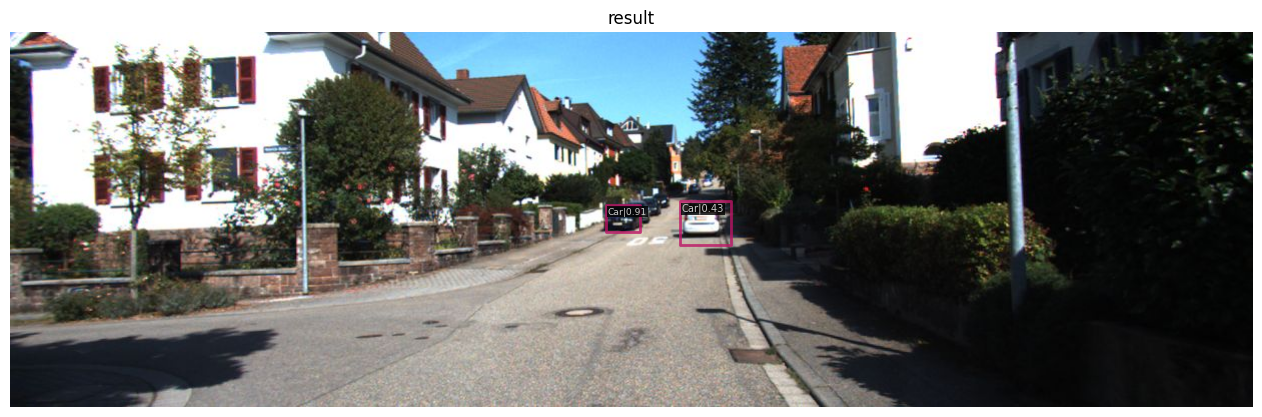

In [25]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

image = 'data/kitti_tiny/training/image_2/000066.jpeg'
model = init_detector('yolov3_kitti.py', 'work_dirs/latest.pth')
result = inference_detector(model, image)
show_result_pyplot(model, image, result)

In [ ]:
mim test mmdet .\yolov3_kitti.py --checkpoint .\work_dirs\latest.pth --eval mAP